## [Data Bootcamp Final Project](https://github.com/sc6354/data_bootcamp_final)
### Project Members: Susan Chen (sc6354), Brandon Eap (be678) , Chloe (Yue Chen, yc2938) 

In [1]:
#import packages
import pandas as pd 
import os 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
plt.style.use('fivethirtyeight')
import matplotlib.collections as collections
%matplotlib inline
from IPython.display import display, Markdown
import ipywidgets as widgets
from ipywidgets import interact
from ipywidgets import Layout, Box
pd.options.mode.chained_assignment = None


In [2]:
# so that we have consist coloring in our plots 
pal = sns.color_palette("pastel")
print(pal.as_hex())

['#a1c9f4', '#ffb482', '#8de5a1', '#ff9f9b', '#d0bbff', '#debb9b', '#fab0e4', '#cfcfcf', '#fffea3', '#b9f2f0']


## This notebook is divided into three sections: 
## 1. Analysis of Top App Categories
## 2. Comparison between Free and Paid
## 3. Topic Modeling of Negative Reviews

Our goal in section 1 is identify the most popular apps across all apps and across the different categories of app to identify which app categories is gaining traction. This can help app developers identify a category of app for which the market is not overly saturated. In section 2, we compare free and paid apps to gain a better understanding of how app pricing can impact ratings and other factors. Lastly, in section 3 we summarize negative reivews for a particular app with topic modeling. This can help app developers to quickly gauge the problems with the app.

In [3]:
#display(Markdown('# `Import Datasets`'))
os.chdir("../data_bootcamp_final/data") #this line depends on your local directory, set it to the folder you save the notebook in 

apps = pd.read_csv('googleplaystore.csv')
reviews = pd.read_csv('googleplaystore_user_reviews.csv')

#Brandon Directory
#apps = pd.read_csv('/Users/brandeap/Documents/GitHub/data_bootcamp_final/data/googleplaystore.csv')
#reviews = pd.read_csv('/Users/brandeap/Documents/GitHub/data_bootcamp_final/data/googleplaystore_user_reviews.csv')

#Chloe directory
#apps = pd.read_csv('/Users/chloe/Documents/GitHub/data_bootcamp_final/data/googleplaystore.csv')
#reviews = pd.read_csv('/Users/chloe/Documents/GitHub/data_bootcamp_final/data/googleplaystore_user_reviews.csv')




## `Data Dictionary` 
This collection of datasets is available on [Kaggle.com](https://www.kaggle.com/lava18/google-play-store-apps). Since both datasets were compiled at the same by the same author, we did not think having two seperate csv files would be a issue. Additionally apps in the 'Reviews' dataset also appears in the 'Apps' dataset, thus excluding 'Reviews' would leave out important information about a particular app that is not contained in 'Apps'.

Apps: 
- App - Application Name 
- Category - Category the App belongs to 
- Rating - Overall user rating of the App
- Reviews - Number of user reviews for app 
- Size - Size of App 
- Installs - number of downloads 
- Type - Is the App paid or Free?
- Price - Price if not free 
- Content Rating - Age group the app is targeted at
- Genres - An app can belong to multiple genres (apart from its main category)

Reviews: 
- App - Name of App
- Translated_Review - user review
- Sentiment - Positive/Negative/Neutral 
- Sentiment_Polarity - Sentiment polarity score 
- Sentiment_Subjectivity - Sentiment subjectivity score 

## `Changing Data types`

In [4]:
print(apps.dtypes)

App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object


In [5]:
# this row appears to be problematic, the values are shifted one place up
apps.iloc[10472]

App               Life Made WI-Fi Touchscreen Photo Frame
Category                                              1.9
Rating                                               19.0
Reviews                                              3.0M
Size                                               1,000+
Installs                                             Free
Type                                                    0
Price                                            Everyone
Content Rating                                        NaN
Genres                                  February 11, 2018
Last Updated                                       1.0.19
Current Ver                                    4.0 and up
Android Ver                                           NaN
Name: 10472, dtype: object

In [6]:
apps.at[10472, ['Last Updated', 'Genres', 'Content Rating', 'Price', 'Type', 'Installs', 'Size', 'Reviews', 'Rating', 'Category']] = ['February 11, 2018', np.nan, 'Everyone', 0, 'Free', '1,000+', '3.0M', 19, 1.9, np.nan]
apps.iloc[10472]

App               Life Made WI-Fi Touchscreen Photo Frame
Category                                              NaN
Rating                                                1.9
Reviews                                                19
Size                                                 3.0M
Installs                                           1,000+
Type                                                 Free
Price                                                   0
Content Rating                                   Everyone
Genres                                                NaN
Last Updated                            February 11, 2018
Current Ver                                    4.0 and up
Android Ver                                           NaN
Name: 10472, dtype: object

In [7]:
# change Rating, Reviews, Size, Installs, and Price to floats
apps['Rating'] = pd.to_numeric(apps['Rating'])
apps['Reviews'] = pd.to_numeric(apps["Reviews"])
# one megabyte is equal to 1000 kilobytes; convert kilobyte to megabyte by dividing by 1000 and remove the M
for i in range(len(apps)):
    if 'k' in apps.Size[i]:
        apps.Size[i] = pd.to_numeric(apps.Size[i][:-1])/1000
    elif 'M' in apps.Size[i]:
        apps.Size[i] = apps.Size[i][:-1]
    elif "Varies with device" in apps.Size[i]: 
        apps.Size[i] = np.nan
apps['Size'] = pd.to_numeric(apps['Size'])
apps['Installs'] = pd.to_numeric(apps['Installs'].str[:-1].str.replace(',', ''))
apps['Price'] = pd.to_numeric(apps['Price'].str.replace('$', ''))
apps['Last Updated'] = pd.to_datetime(apps['Last Updated'])

<ipython-input-7-b4ab4a97010f>:14: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  apps['Price'] = pd.to_numeric(apps['Price'].str.replace('$', ''))


In [8]:
apps = apps.replace('empty',np.NaN).dropna()
apps['Last Updated']=pd.to_datetime(apps['Last Updated'])
Each_Year = apps['Last Updated'].dt.year
apps['Year']=Each_Year

In [9]:
apps.describe()

,Rating,Reviews,Size,Installs,Price,Year
count,7723.000000,7.723000e+03,7723.000000,7.723000e+03,7723.000000,7723.000000
mean,4.173935,2.948983e+05,22.970456,8.424070e+06,1.128169,2017.338211
std,0.544638,1.863933e+06,23.449629,5.015742e+07,17.408036,1.161332
min,1.000000,1.000000e+00,0.008500,1.000000e+00,0.000000,2010.000000
25%,4.000000,1.075000e+02,5.300000,1.000000e+04,0.000000,2017.000000
50%,4.300000,2.332000e+03,14.000000,1.000000e+05,0.000000,2018.000000
75%,4.500000,3.905300e+04,33.000000,1.000000e+06,0.000000,2018.000000
max,5.000000,4.489389e+07,100.000000,1.000000e+09,400.000000,2018.000000


# `Section 1`

## 1.1 What are the top ten categories of apps by the amount of installs?

### One indicator for the success and popularity of an app is the amount of downloads/installs.

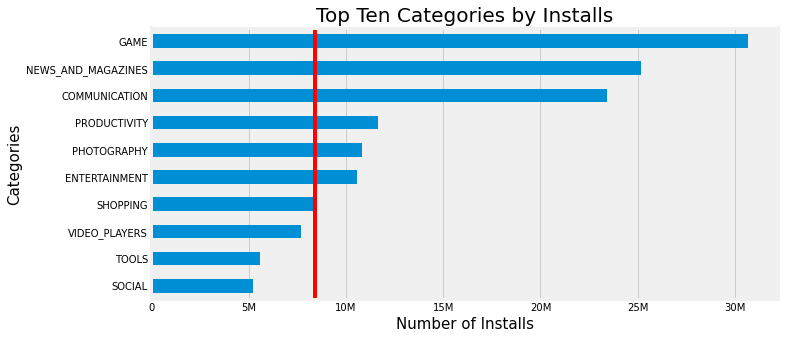

In [10]:
top_ten_cat = apps.groupby('Category')['Installs'].mean().sort_values(ascending=False).head(10)
top_ten_cat = top_ten_cat.sort_values(ascending=True)
fig,ax = plt.subplots()
top_ten_cat.plot.barh(ax=ax, figsize=(10,5))
plt.xticks((0, 5000000, 10000000, 15000000, 20000000, 25000000, 30000000), ('0', '5M', '10M', '15M', '20M', '25M', '30M'))
plt.axvline(apps['Installs'].mean(), 0, 11, color='red')

ax.set_title('Top Ten Categories by Installs', size=20)
ax.set_ylabel('Categories', size=15)
ax.set_xlabel('Number of Installs', size=15)
ax.tick_params(axis='x', rotation=0)
ax.xaxis.grid(True)
ax.yaxis.grid(False)


### The amount of apps downloaded in the game category is the highest. To compare, the average amount of installs is 8,424,070 installs, whereas the game category is more than 30 million installs. App developers who create game apps can generally see more installs compared to other categories.

## 1.2 What are the top ten categories of apps by the amount of ratings?

### Although looking at installs is a good way to gauge popularity, ratings is also a good way to see if users enjoy certain categories more than others.

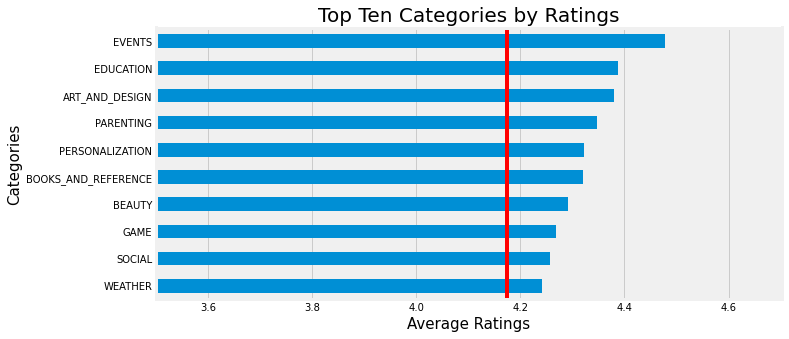

In [11]:
top_ten_rating = apps.groupby('Category')['Rating'].mean().sort_values(ascending=False).head(10)
top_ten_rating = top_ten_rating.sort_values(ascending=True)
fig,ax = plt.subplots()
top_ten_rating.plot.barh(ax=ax, figsize=(10,5))
plt.axvline(apps['Rating'].mean(), 0, 11, color='red')

ax.set_xlim(3.5)
ax.set_title('Top Ten Categories by Ratings', size=20)
ax.set_ylabel('Categories', size=15)
ax.set_xlabel('Average Ratings', size=15)
ax.tick_params(axis='x', rotation=0)
ax.xaxis.grid(True)
ax.yaxis.grid(False)

### The game category has more average installs, but the events category has a higher average rating. The top ten apps all have higher ratings than the 4.17 average. However, if a category has low users and high ratings, then the ratings are not good indicators of popularity and success.

## 1.3 What are the top ten categories of apps by the amount of installs and ratings?

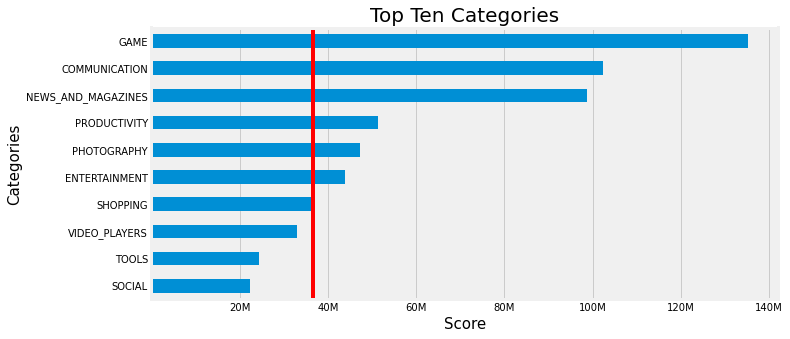

In [12]:
apps['Score'] = apps['Installs']*apps['Rating']

top_ten = apps.groupby('Category')['Score'].mean().sort_values(ascending=False).head(10)
top_ten = top_ten.sort_values(ascending=True)
fig,ax = plt.subplots()
top_ten.plot.barh(ax=ax, figsize=(10,5))
plt.xticks((20000000, 40000000, 60000000, 80000000, 100000000, 120000000, 140000000), ('20M', '40M', '60M', '80M', '100M', '120M', '140M'))
plt.axvline(apps['Score'].mean(), 0, 11, color='red')

ax.set_title('Top Ten Categories', size=20)
ax.set_ylabel('Categories', size=15)
ax.set_xlabel('Score', size=15)
ax.tick_params(axis='x', rotation=0)
ax.xaxis.grid(True)
ax.yaxis.grid(False)

### To consider both installs and ratings, we multiplied each app's rating with its number of installs and averaged them. The game category has the highest average installs and ratings, with most of the categories in the top ten ratings graph not included in this graph. The graph indicates that the game category is the category that is gaining popularity and traction in 2018.

## 1.3 What are the top ten categories of apps by the amount of installs and ratings?

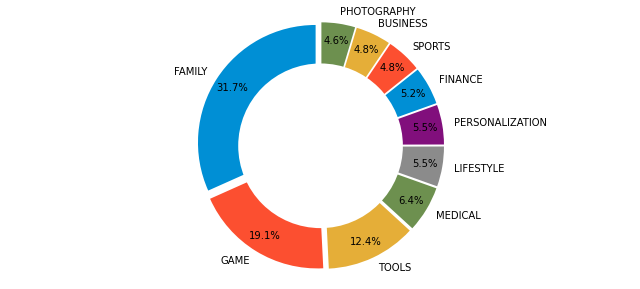

In [13]:
top_number_apps = apps.groupby('Category')['App'].count().sort_values(ascending=False).head(10)
top_number_apps.sort_values(ascending=True)
fig,ax = plt.subplots()
top_number_apps.plot.pie(ax=ax, figsize=(10,5), textprops={'fontsize': 10}, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = (0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05))
ax.set_ylabel('')
ax.axis('equal')

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

### Although the game category has the most average installs and ratings, the family category has the most amount of apps in the Google Play Store. However, the family category includes casual games like board games, puzzles, and kids games, which means that games are still the most popular category.

# `Section 2`

## 2.1 What is the breakdown of App types (free or paid)?

Text(0, 0.5, 'Total Number')

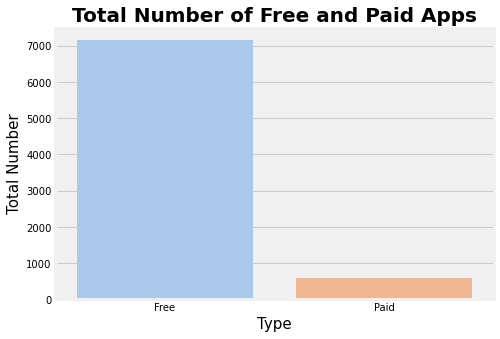

In [14]:
fig,ax = plt.subplots(figsize=(7,5))
sns.countplot(x='Type',data=apps, palette=('#a1c9f4', '#ffb482'))
ax.set_title('Total Number of Free and Paid Apps', loc='center', fontsize=20, fontweight='bold')
ax.set_xlabel('Type',fontsize=15)
ax.set_ylabel('Total Number',fontsize=15)

### As expected, there are more free apps than paid apps. Most apps in the Google Play store and iTunes follow a "freemium" model, in which it is free to download the app, but the app can have microtransactions (i.e. most gaming apps) or fees after trial. Thus, we cannot say that free apps are entirely free since some may charge a one-time fee for extra features or a monthly/yearly subscription fee for use after the trial period even if it is free to download. This is also consistent with our belief because most users prefer free apps or apps with some ads, leading app developers and  businesses (i.e. apps for ecommmerce) to price their apps at $0 to encourage usage by users.

## 2.2 Growth of Free and Paid Apps

In [15]:
time_d=pd.DataFrame()
for i in range(2012,2019,1):
    td = apps.loc[apps['Year'] == i,:]
    for m in td['Type'].unique():
        time_d.loc[i,m]= td.loc[td['Type']==m,'Type'].count()
time_d

,Free,Paid
2012,18.0,2.0
2013,66.0,22.0
2014,135.0,48.0
2015,312.0,62.0
2016,532.0,68.0
2017,1259.0,125.0
2018,4811.0,247.0


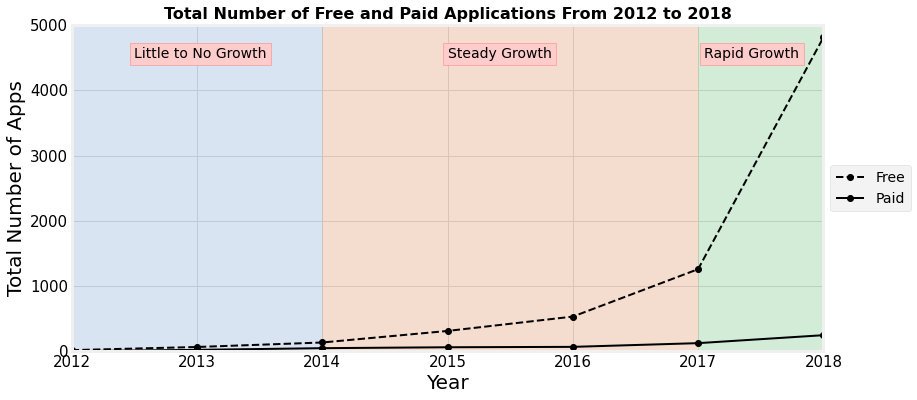

In [16]:
fig,ax= plt.subplots(1,1,figsize=(12,6))
plt.grid(True)
plt.style.use('fivethirtyeight')
patches = []
rect1 = plt.Rectangle((2012.0, 0.0), 2.0, 5000)
rect2 = plt.Rectangle((2014.0, 0.0), 3.0, 5000)
rect3 = plt.Rectangle((2017.0, 0.0), 2.0, 5000)
patches.append(rect1)
patches.append(rect2)
patches.append(rect3)
p = collections.PatchCollection(patches, color =('#a1c9f4', '#ffb482', '#8de5a1'), alpha=.3) 
ax.add_collection(p)
# plot lines
time_d['Free'].plot(ax=ax,marker='o', ls= '--',lw = 2,color='black')
time_d['Paid'].plot(ax=ax,marker='o',lw = 2,color='black')
ax.set_title('Total Number of Free and Paid Applications From 2012 to 2018',size = 16,fontweight='bold')
ax.set_ylim(0,5000)
ax.set_xlim(2012,2018)
ax.set_ylabel('Total Number of Apps',size=20)
ax.set_xlabel('Year',size=20)
plt.text(2012.5, 4500, 'Little to No Growth', bbox=dict(boxstyle="square",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8),))
plt.text(2015, 4500, 'Steady Growth', bbox=dict(boxstyle="square",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8),))
plt.text(2017.05, 4500, 'Rapid Growth', bbox=dict(boxstyle="square",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8),))                 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### This time series lines up with changes to the Play Store also exactly as when those changes were put into place. Our goal with this plot and the following plot is to help explain and visualize the rise of free apps after 2017. Google's Play Store and Apple's App Store first launched in 2008. Since our dataset only contains information about Google Play Store apps since 2012, we refrain from applying our analysis to earlier years and Apple apps (althought a similiar case can be made too). This graph can be generally divided into three phases: pratically no growth (2012-2014); steadily growth (2014-2017); and rapid growth (2017-present). Uncoincidentally, Google implemented drastic changes at the start of each of those phases. Prior to 2014, Google did not make huge improvements to its app stores besides increasing the app size from 2GB to 4GB and adding in-app billing. 

### In 2015, Google introduced tools that make it eaiser for app developers to create apps such as A/B test experiments. This changes was further complemented by a series of changes in 2016 that included labeling apps with ads, introducing more pre-launch tools for developers, introducing new app categories, and most importantly changing the revenue model for developers. Instead of earning 70% of revenue from app subscritions, developers can now earned 85% of revenue. This change was perhaps the most significant since developers can effectively make more revenue per app. Post 2017 Play Store is essentially the storefront that users are accustomed to seeing. Google introduced the Play Store to all Chromebooks in 2017. This single change is very likely to have resulted in the rapid uptick of downloads of free apps because previously, user could `only` download apps on an Andriod phone. By allowing user to also have access to their apps on their Chromebooks, Google has widen the market for play store apps and eroded the line between computer applications and mobile applications. 

## 2.3 Distribution of App Ratings by Year

In [17]:
type_agg=apps.groupby('Type').mean()
type_agg['Count']=apps.groupby('Type')['App'].count()
type_agg

,Rating,Reviews,Size,Installs,Price,Year,Score,Count
Type,,,,,,,,
Free,4.167562,318141.221662,23.157842,9.097601e+06,0.00000,2017.394207,3.952642e+07,7146
Paid,4.252860,7040.149047,20.649735,8.256305e+04,15.10026,2016.644714,3.676182e+05,577


In [18]:
@interact
def hist(Year = widgets.IntRangeSlider(description='Year(s):',min=2012, max=2018, step =1,value= [2012,2012],)):
    fig,ax = plt.subplots(figsize=(15,8))
    #if Year == 'All years':
     #   sns.histplot(data=apps,x='Rating', color='#a1c9f4', stat='count', bins=10, kde=True)
    #else: 
    # filter data by the year range
    data = apps[(apps['Year']>=Year[0]) & (apps['Year']<=Year[1])]
    sns.histplot(data=data,x='Rating', color='#a1c9f4', stat='count', bins=10, kde=True)
    range= ""
    if Year[0]== Year[1]:
        range = str(Year[0])
    else:
        range = str(Year[0]) + ' to ' + str(Year[1])

    free_avg = data[data['Type']== 'Free']['Rating'].mean()
    paid_avg = data[data['Type']== 'Paid']['Rating'].mean()
    avg = apps['Rating'].mean()
    plt.axvline(free_avg, 0, 11, color='red')
    plt.axvline(paid_avg, 0, 11, color='green')
    plt.axvline(avg, 0, linewidth='5', linestyle=':',color='black' )
    ax.set_title('Distributions of All App Rating for ' + range, loc='center', fontsize=20,fontweight='bold')
    ax.set_xlabel('Ratings',fontsize=20)
    ax.set_ylabel('Total Number of Apps',fontsize=20)
    plt.legend(['Distribution Line','Average Rating of Free Apps', 'Average Rating of Paid Apps', 'Average of all Apps'],fontsize = 20, loc='best')
    plt.tick_params(labelsize=20)


interactive(children=(IntRangeSlider(value=(2012, 2012), description='Year(s):', max=2018, min=2012), Output()…

## what are the trends in ratings? blah blah blah 

In [19]:
# pip install --upgrade seaborn
# pip install --upgrade matplotlib

## 2.4 another subsection

([<matplotlib.axis.XTick at 0x7f97b14f7190>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

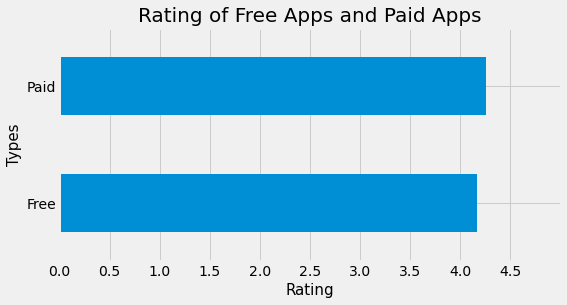

In [20]:
fig,ax=plt.subplots()
type_agg['Rating'].plot.barh(ax=ax,figsize=(8,4))
ax.set_title('Rating of Free Apps and Paid Apps',size=20)
ax.set_ylabel('Types',size=15)
ax.set_xlabel('Rating', size=15)
#ax.yaxis.grid(True)
ax.xaxis.grid(True)
ax.set_xlim(0,5) 
plt.xticks([0,0.5,1,1.5, 2,2.5, 3, 3.5,4, 4.5])
#how to set step
#ax.get_children()[list(type_agg.index).index('Paid')].set_color('#003300')
#ax.get_children()[list(type_agg.index).index('Free')].set_color('#FFCC99')

# `Section 2`

# some ideas: what is the most popular paid app?, what app has the most negative reviews and what is its rating and plotting number of ratings against proportion of negative review. What is the most popular app by category and target audience?



# `Section 3: Topic Modeling of Reviews `

### In this section, we analyze app reviews. Apps can acquire a plethora of reviews and it is often impractical for a business or developer to read them all. A quicker and less costly option to summarize reviews and extract the key points. This is our goal for this section. We focus our model on negative reviews because it more advantageous for a developer to look into negative reviews than it is to look into positive reviews when attempting to figure out what features of their app to improve and debug.

In [21]:
reviews

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000
...,...,...,...,...,...
64290,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64291,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64292,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64293,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN


In [22]:
# remove rows with NaN
reviews = reviews.dropna()
# check how many apps are in the reviews dataset and subset the one with the most reviews to model
reviews.App.value_counts()

Bowmasters                        312
Helix Jump                        273
Angry Birds Classic               273
Calorie Counter - MyFitnessPal    254
Duolingo: Learn Languages Free    240
                                 ... 
Google Slides                       1
Draw In                             1
Free Live Talk-Video Call           1
Calendar+ Schedule Planner App      1
Best Fiends - Free Puzzle Game      1
Name: App, Length: 865, dtype: int64

In [23]:
# create a dataframe of the App with the most reviews
bm_df = reviews[reviews['App']=="Bowmasters"]
bm_df

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
16887,Bowmasters,Really like game far. Great gameplay lots fun....,Positive,0.116667,0.542593
16888,Bowmasters,Easy play round two minutes. Characters hilari...,Positive,0.165152,0.560606
16889,Bowmasters,I would give game stars many problems. Lag eve...,Negative,-0.357143,0.571429
16890,Bowmasters,"It's ok, making us pay per week ads absurd edi...",Positive,0.016667,0.441667
16891,Bowmasters,"Should vary videos required watch, least give ...",Positive,0.042857,0.394286
...,...,...,...,...,...
17202,Bowmasters,It really good lots fun addictive I would say ...,Positive,0.071429,0.514286
17203,Bowmasters,Its pretty addicting please fix guy CD broken....,Positive,0.016667,0.533333
17204,Bowmasters,This magical game children play. If like wonde...,Positive,0.175000,0.700000
17205,Bowmasters,Little reason keep playing. Only way earn coin...,Positive,0.022500,0.520000


## 3.1 Starting off easy: How many negative reviews do Bowmasters have?

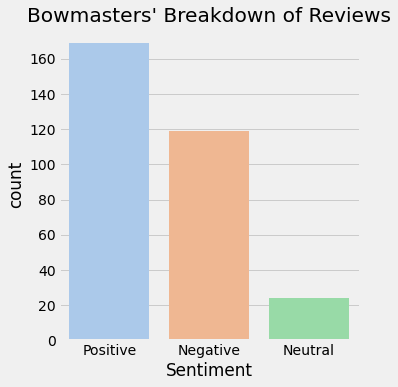

In [24]:
display(Markdown('## 3.1 Starting off easy: How many negative reviews do Bowmasters have?'))
sns.catplot(x="Sentiment", kind="count", data=bm_df, palette="pastel").set(title="Bowmasters' Breakdown of Reviews")


### The barplot clearly illustrates that approximately half of Bowmaster's revies are either negative or neutral. This is not a good situation to be in as the app clearly has room to improve. 

## 3.2 We know that Bowmasters has many negative reviews but what are users complaining about?'

In [25]:
neg_reviews = bm_df[bm_df["Sentiment"]=="Negative"]
neg_reviews

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
16889,Bowmasters,I would give game stars many problems. Lag eve...,Negative,-0.357143,0.571429
16895,Bowmasters,The game entertaining game randomly send ad pa...,Negative,-0.260000,0.500000
16900,Bowmasters,This game great even 5 year old brother plays ...,Negative,-0.036533,0.455952
16901,Bowmasters,I rate 4 stars ads chests really annoying I'm ...,Negative,-0.182727,0.570909
16905,Bowmasters,I got I really like it! Too much blood too! An...,Negative,-0.020833,0.466667
...,...,...,...,...,...
17196,Bowmasters,Loved game. Hated would freeze everytime I ref...,Negative,-0.108333,0.575000
17198,Bowmasters,Ad based chest drops horrendous game whole mem...,Negative,-0.100000,0.400000
17199,Bowmasters,I really like game fun play crashes often. Als...,Negative,-0.013333,0.246667
17201,Bowmasters,Great game pass time with. Almost reminds angr...,Negative,-0.033333,0.716667


In [26]:
import nltk; nltk.download('stopwords')



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brandeap/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
import re
from pprint import pprint 
from nltk.corpus import stopwords
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
# Plotting tools
import pyLDAvis.gensim_models as gensimvis 
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [28]:
# NLTK stop words
stop_words = stopwords.words('english')
neg = neg_reviews['Translated_Review'].values.tolist()

In [29]:
print(neg[10:15])
# the reviews look pretty cleans, so we can move straight into tokenizaiton 

['Loved game. Hated would freeze everytime I refused targeted ads. Disappointed. Was really enjoying much', "Ad based chest drops horrendous game whole member ship scheme y'all adopted pitiful happened buying 2 bucks", "I really like game fun play crashes often. Also I get passed second opponent tournament mode screen goes black I can't continue.", 'Great game pass time with. Almost reminds angry birds', 'Its fun short round pvp ridiculously gruesome kill scenes done cartoon fashion. Nothing negative say; I look forward unlocking characters.']


In [30]:
# function tokenize words 
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

review_words = list(sent_to_words(neg))
print(review_words[:1])

[['would', 'give', 'game', 'stars', 'many', 'problems', 'lag', 'everywhere', 'game', 'ads', 'make', 'worse', 'mind', 'watching', 'game', 'awful', 'it', 'makes', 'gameplay', 'unplayable', 'unenjoyable', 'please', 'fix', 'problems']]


In [31]:
# these are functions for removing stopwords, creating bigrams and trigrams, performing lemmatization 
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

bigram = gensim.models.Phrases(review_words , min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[review_words ], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [32]:
# Remove Stop Words
rev_words_nostops = remove_stopwords(review_words)
# Form Bigrams
rev_words_bigrams = make_bigrams(rev_words_nostops)
# Initialize spacy 'en' model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# Perform lemmatization keeping only noun, adj, vb, adv
rev_lemmatized = lemmatization(rev_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# print the first review to view results
print(rev_lemmatized[:1])

[['give', 'game', 'star', 'many', 'problem', 'lag', 'everywhere', 'game', 'ad', 'make', 'bad', 'mind', 'watch', 'game', 'awful', 'make', 'gameplay', 'unplayable', 'unenjoyable', 'fix', 'problem']]


In [33]:
# create corpus 
words = corpora.Dictionary(rev_lemmatized)
# create term document frequency 
corpus = [words.doc2bow(rev) for rev in rev_lemmatized]
print(corpus[:1])
words[0]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 3), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1)]]


'ad'

In [34]:
# build the LDA topic model assuming that the number of topics is 10
topics = gensim.models.ldamodel.LdaModel(corpus = corpus,id2word= words,num_topics=10,random_state=100,
                                         update_every=1,chunksize=30,alpha='auto',per_word_topics=True)

In [35]:
# View topics
pprint(topics.print_topics())
doc_lda = topics[corpus]

[(0,
  '0.083*"game" + 0.039*"chest" + 0.036*"reward" + 0.032*"player" + '
  '0.029*"great" + 0.026*"pass" + 0.026*"buy" + 0.026*"member" + 0.026*"ship" '
  '+ 0.026*"time"'),
 (1,
  '0.126*"game" + 0.052*"fun" + 0.050*"ad" + 0.033*"match" + 0.029*"good" + '
  '0.025*"minute" + 0.024*"weapon" + 0.023*"bloody" + 0.022*"pop" + '
  '0.020*"think"'),
 (2,
  '0.070*"happen" + 0.069*"ad" + 0.068*"watch" + 0.067*"online" + '
  '0.064*"never" + 0.064*"still" + 0.052*"hit" + 0.049*"time" + 0.042*"win" + '
  '0.033*"die"'),
 (3,
  '0.123*"game" + 0.064*"make" + 0.040*"problem" + 0.039*"horrible" + '
  '0.037*"many" + 0.035*"video" + 0.033*"give" + 0.032*"suck" + 0.029*"people" '
  '+ 0.027*"bad"'),
 (4,
  '0.068*"get" + 0.053*"second" + 0.044*"game" + 0.037*"screen" + '
  '0.036*"tournament" + 0.035*"also" + 0.033*"crash" + 0.032*"chance" + '
  '0.031*"degree" + 0.030*"fun"'),
 (5,
  '0.043*"ad" + 0.042*"always" + 0.037*"pvp" + 0.037*"character" + '
  '0.035*"chest" + 0.028*"second" + 0.028*"rea

### Topic 0 is represented as 0.083*"game" + 0.039*"chest" + 0.036*"reward" + 0.032*"player" + 0.029*"great" + 0.026*"pass" + 0.026*"buy" + 0.026*"member" + 0.026*"ship" '+ 0.026*"time". This means that the top 10 terms that contribute to Topic are 'game', 'chest', 'reward', and so on. The probability or weight of 'game' on Topic 0 is .083. The greater the weight, the more important that term is to the topic.

In [36]:
# Evaluating the model with perplexity and coherence scores
print('\nPerplexity: ', topics.log_perplexity(corpus)) 
coherence_model_lda = CoherenceModel(model=topics, texts=rev_lemmatized, dictionary=words, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -4.874260210677197

Coherence Score:  0.5788043767975338


### Perplexity is how well the model fits the data and lower the value, better the fit. However, the statistic alone is meaningless, since we do not have anything to compare it to. 

In [37]:
# Run topic modeling with different nums of topics, and compute perplexity and coherence for each model 
def compute_scores(dictionary, corpus, texts, limit, start=2):
    perplexity_scores = []
    coherence_scores =[]
    models=[]
    for num_topics in range(start, limit):
        model = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word= words, num_topics=num_topics, random_state=100, update_every=1,
                                                chunksize=30, alpha='auto')
        models.append(model)
        perplexity = model.log_perplexity(corpus)
        perplexity_scores.append(perplexity)
        coherenceModel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_scores.append(coherenceModel.get_coherence())
    return models, perplexity_scores, coherence_scores

In [38]:
model_list, perplexity_scores, coherence_scores = compute_scores(dictionary=words, corpus=corpus, texts = rev_lemmatized, start=2, limit = 25)

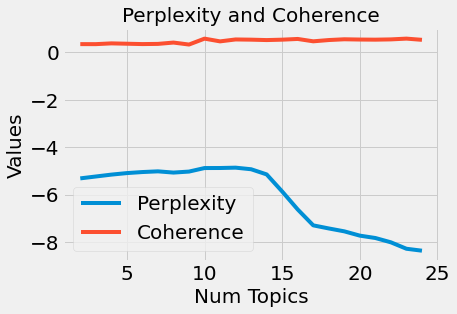

In [39]:
# plot results 
limit=25
start=2
x = range(start, limit)
plt.plot(x, perplexity_scores)
plt.plot(x, coherence_scores)
plt.figsize =(3,5)
plt.title("Perplexity and Coherence", fontsize = 20)
plt.xlabel("Num Topics", fontsize = 20)
plt.ylabel("Values", fontsize = 20)
plt.legend(['Perplexity', 'Coherence'],fontsize = 20, loc='best')
plt.tick_params(labelsize=20)
plt.show()

### The coherence score does not increase as the number of topics increase. Up to 15, the perplexity score does not decrease as the number of topics increase. This indicates that the ideal number of topics is likely to between 2 and 10. We avoid selecting any number over 10, since the model could overfit the data and create topics that have too much overlap. 

In [40]:
# Select the k = 5 as the optimal model and print the topics
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))


[(0,
  '0.069*"game" + 0.037*"player" + 0.033*"reward" + 0.028*"include" + '
  '0.026*"great" + 0.023*"buy" + 0.023*"server" + 0.023*"member" + '
  '0.023*"ship" + 0.023*"play"'),
 (1,
  '0.087*"game" + 0.058*"ad" + 0.033*"use" + 0.030*"get" + 0.028*"stop" + '
  '0.027*"much" + 0.026*"virus" + 0.026*"randomly" + 0.025*"also" + '
  '0.025*"match"'),
 (2,
  '0.042*"ad" + 0.040*"online" + 0.033*"watch" + 0.032*"happen" + '
  '0.030*"still" + 0.030*"never" + 0.028*"pvp" + 0.026*"game" + 0.024*"hit" + '
  '0.022*"time"'),
 (3,
  '0.114*"game" + 0.045*"make" + 0.029*"well" + 0.020*"problem" + 0.019*"lag" '
  '+ 0.018*"time" + 0.018*"horrible" + 0.018*"bad" + 0.018*"many" + '
  '0.016*"mode"'),
 (4,
  '0.088*"game" + 0.050*"fun" + 0.027*"second" + 0.026*"get" + 0.024*"play" + '
  '0.021*"screen" + 0.019*"suck" + 0.019*"degree" + 0.018*"tournament" + '
  '0.018*"pass"'),
 (5,
  '0.052*"game" + 0.041*"chest" + 0.037*"character" + 0.037*"always" + '
  '0.036*"get" + 0.031*"ad" + 0.027*"coin" + 0

In [41]:
# visualize the optimal model, namely the top 10 terms in each topic
def plot_topics (topic_num, axs):
    topic_dict = {}
    for i in range(len(optimal_model.show_topic(topic_num))):
        topic_dict[optimal_model.show_topic(topic_num)[i][0]] = optimal_model.show_topic(topic_num)[i][1]

    topic_terms = list(topic_dict.keys())
    beta = [float(topic_dict[k]) for k in topic_terms]
    plot = sns.barplot(x=beta, y = topic_terms, color = 'blue', ax = axs)
    plot.set_title("Topic " + str(topic_num +1), fontsize=25)
    plot.tick_params(labelsize=20)
    return plot

<AxesSubplot:title={'center':'Topic 5'}>

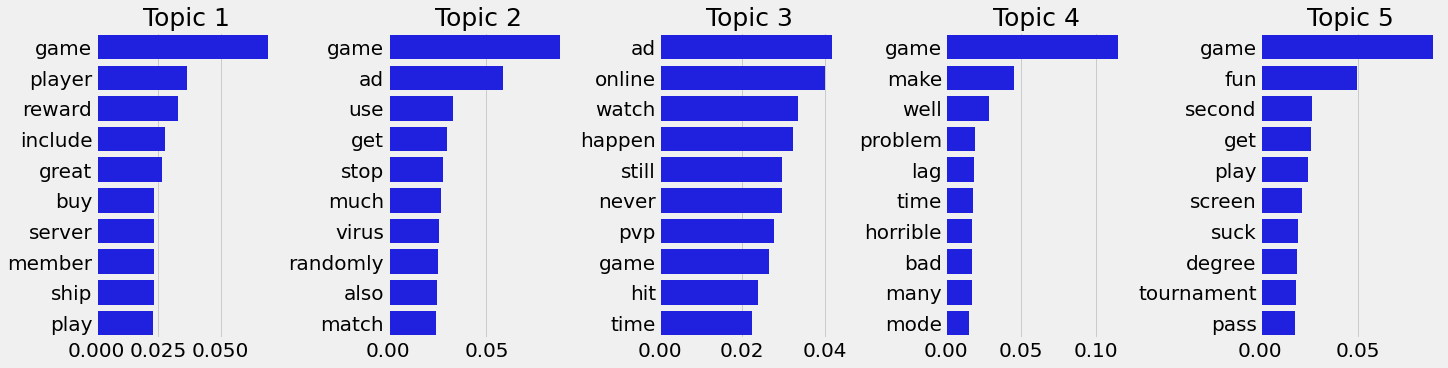

In [42]:
plt.rcParams["figure.figsize"] = (20,5)
fig, axs = plt.subplots(ncols= 5, constrained_layout=True)
plot_topics(0, axs[0])
plot_topics(1, axs[1])
plot_topics(2, axs[2])
plot_topics(3, axs[3])
plot_topics(4, axs[4])
#fig.tight_layout()

### Judging from these topics, if we did not know that Bowmasters is a gaming application, the topics make it very obvious that it is. Its seems like Bowmasters' most prevalent problems are perhaps too many microtransactions in the game, too many ads, a persistent and horrible lag, and screen freezes or blackouts. Since topics 2 and 3 both contain 'ad', it might be in Bowmasters' interest to resolve this issue first. A similiar analysis can be conduct for Bowmasters' positive review to gauge areas of their App that they are excelling in.